<font size="5"><center> <b>Sandpyper: sandy beaches SfM-UAV analysis tools</b></center></font>
<font size="4"><center> <b> Example 5a - Beachface Cluster Dynamics indices - transect level </b></center> <br>

    
<center><img src="images/banner.png" width="80%"  /></center>

<font face="Calibri">
<br>
<font size="5"> <b>Transect scale beachface behavioural modelling</b></font>

<br>
<font size="4"> <b> Nicolas Pucino; PhD Student @ Deakin University, Australia </b> <br>

<font size="3">These indices represents the tendency of the location, or transect, to either erode or accrete, based on the temporal succession of sand-only change. <br>

<b>This notebook covers the following concepts:</b>

- Modelling r-BCDs at the transect scale.
- Plotting.
- Sensitivity analysis.
</font>


</font>

In [98]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import itertools
from tqdm.notebook import tqdm


from sandpyper.outils import getLoc, getDate,coords_to_points
from sandpyper.dynamics import  steady_state_transect, compute_rBCD_transects, infer_weights

crs_dict_string={"mar":{'init': 'epsg:32754'},
         "leo":{'init': 'epsg:32755'}}

pd.options.mode.chained_assignment = None  # default='warn'

This time, as previously specified, we use the __full dh dataset__, not the hotspot filtered one.

In [230]:
in_file=r"C:\my_packages\doc_data\markov_tagged\markov_tagged_fulldh_df.csv"
dirNameTrans=r"C:\my_packages\doc_data\transects\\"

dataset=pd.read_csv(in_file)

dataset["coordinates"]=dataset.geometry.apply(coords_to_points)
dataset_gdf=gpd.GeoDataFrame(dataset, geometry="coordinates",crs=crs_dict_string['mar'])
dataset_gdf.sort_values(['date_pre'], inplace=True)

C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [231]:
dataset_gdf.head()

,Unnamed: 0,geometry,location,tr_id,distance,dt,date_pre,date_post,z_pre,z_post,dh,jc_bin,markov_tag,coordinates
31091,31091,POINT (731467.5216240293 5705156.429089419),mar,3,45.2,dt_0,2018-06-01,2018-06-21,2.166688,3.388355,1.221667,3,hd,POINT (731467.522 5705156.429)
29121,28352,POINT (731568.3976020521 5705480.122417443),mar,20,43.2,dt_0,2018-06-01,2018-06-21,1.144477,1.658706,0.514229,3,hd,POINT (731568.398 5705480.122)
29122,28353,POINT (731568.3123749822 5705480.174727542),mar,20,43.3,dt_0,2018-06-01,2018-06-21,1.167545,1.662670,0.495125,3,hd,POINT (731568.312 5705480.175)
29123,28354,POINT (731568.2271479121 5705480.227037642),mar,20,43.4,dt_0,2018-06-01,2018-06-21,1.187715,1.666856,0.479141,2,md,POINT (731568.227 5705480.227)
29124,28355,POINT (731568.1419208422 5705480.279347742),mar,20,43.5,dt_0,2018-06-01,2018-06-21,1.200375,1.672475,0.472100,2,md,POINT (731568.142 5705480.279)


Let's use only Marengo data, which has a longer timeseries compared to St. Leonards.

In [4]:
dataset_mar=dataset.query("location=='mar'")
dataset_mar

,Unnamed: 0,geometry,location,tr_id,distance,dt,date_pre,date_post,z_pre,z_post,dh,jc_bin,markov_tag,coordinates
2725,4733,POINT (731579.306667006 5705473.42672466),mar,20,30.4,dt_7,2019-03-13,2019-05-16,1.392407,1.127059,-0.265348,3,se,POINT (731579.307 5705473.427)
2726,4734,POINT (731579.221439936 5705473.47903476),mar,20,30.5,dt_7,2019-03-13,2019-05-16,1.414008,1.135922,-0.278085,3,se,POINT (731579.221 5705473.479)
2727,4735,POINT (731579.1362128661 5705473.53134486),mar,20,30.6,dt_7,2019-03-13,2019-05-16,1.427494,1.147608,-0.279886,3,se,POINT (731579.136 5705473.531)
2728,4742,POINT (731556.3417177059 5705441.53390942),mar,18,36.5,dt_7,2019-03-13,2019-05-16,1.774062,1.608972,-0.165090,3,se,POINT (731556.342 5705441.534)
2729,4743,POINT (731555.141984757 5705442.03454986),mar,18,37.8,dt_7,2019-03-13,2019-05-16,1.847479,1.734514,-0.112966,4,ue,POINT (731555.142 5705442.035)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31087,31087,POINT (731468.0187435427 5705156.375496609),mar,3,44.7,dt_0,2018-06-01,2018-06-21,2.075071,2.708724,0.633653,3,hd,POINT (731468.019 5705156.375)
31088,31088,POINT (731467.8198957373 5705156.396933733),mar,3,44.9,dt_0,2018-06-01,2018-06-21,2.090222,2.918043,0.827821,3,hd,POINT (731467.820 5705156.397)
31089,31089,POINT (731467.7204718346 5705156.407652295),mar,3,45.0,dt_0,2018-06-01,2018-06-21,2.116984,3.143203,1.026220,3,hd,POINT (731467.720 5705156.408)
31090,31090,POINT (731467.621047932 5705156.418370857),mar,3,45.1,dt_0,2018-06-01,2018-06-21,2.140646,3.303227,1.162581,3,hd,POINT (731467.621 5705156.418)


As no transitions are represented, there is no need to use weights. However, the use of weights can be implemented with passing the weights dictionary.

In [232]:
# Weights are all ones, which means no weights.

weights_dict={"ee":1,"ed":1,
        "he":1,"hd":1,
        "me":1,"md":1,
        "se":1,"sd":1,
        "ue":1,"ud":1}

label_order=['ed', 'hd', 'md', 'sd', 'ud', 'ue', 'se', 'me', 'he', 'ee']

two parameters are important:
* __min_points__: the minimum required valid points per transect to consider a transect reliable.
* __thresh__: the minimum number of timesteps required to retain a transect.


In [11]:
import numpy as np
from scipy.stats import median_abs_deviation, shapiro, normaltest
from statsmodels.api import qqplot
from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
import itertools
from itertools import product, combinations

from pysal.explore.giddy.markov import Markov
import matplotlib.pyplot as plt
import seaborn as sb

from sandpyper.outils import getListOfFiles, getLoc, create_spatial_id

In [233]:
weights_dict={"ee":1,"ed":1,
        "he":1,"hd":1,
        "me":1,"md":1,
        "se":1,"sd":1,
        "ue":1,"ud":1}

loc_codes=["mar","leo"]
loc_search_dict = {   'leo': ['St','Leonards','leonards','leo'],
                      'mar': ['Marengo','marengo','mar'] }
crs_dict_string= {
                 'mar': {'init': 'epsg:32754'},
                 'leo':{'init': 'epsg:32755'}
                 }

dirNameTrans=r'C:\my_packages\sandpyper\tests\test_data\transects'

label_order=["ed", "hd", "md", "sd", "ud", "nnn", "ue", "se", "me", "he", "ee"]
geo=True

In [170]:
from sandpyper.dynamics import attach_trs_geometry

In [234]:
dataset

,Unnamed: 0,geometry,location,tr_id,distance,dt,date_pre,date_post,z_pre,z_post,dh,jc_bin,markov_tag,coordinates
0,0,POINT (299901.7782793006 5773692.070767866),leo,69,26.8,dt_5,2019-03-28,2019-07-31,0.223866,0.112838,-0.111029,4,ue,POINT (299901.778 5773692.071)
1,1,POINT (299901.4828779417 5773692.018441608),leo,69,27.1,dt_5,2019-03-28,2019-07-31,0.256890,0.152005,-0.104885,4,ue,POINT (299901.483 5773692.018)
2,2,POINT (299901.2859437025 5773691.983557437),leo,69,27.3,dt_5,2019-03-28,2019-07-31,0.283333,0.176710,-0.106624,4,ue,POINT (299901.286 5773691.984)
3,3,POINT (299901.1874765829 5773691.966115351),leo,69,27.4,dt_5,2019-03-28,2019-07-31,0.305573,0.188821,-0.116752,4,ue,POINT (299901.187 5773691.966)
4,4,POINT (299901.0890094633 5773691.948673265),leo,69,27.5,dt_5,2019-03-28,2019-07-31,0.329158,0.197999,-0.131160,4,ue,POINT (299901.089 5773691.949)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31087,31087,POINT (731468.0187435427 5705156.375496609),mar,3,44.7,dt_0,2018-06-01,2018-06-21,2.075071,2.708724,0.633653,3,hd,POINT (731468.019 5705156.375)
31088,31088,POINT (731467.8198957373 5705156.396933733),mar,3,44.9,dt_0,2018-06-01,2018-06-21,2.090222,2.918043,0.827821,3,hd,POINT (731467.820 5705156.397)
31089,31089,POINT (731467.7204718346 5705156.407652295),mar,3,45.0,dt_0,2018-06-01,2018-06-21,2.116984,3.143203,1.026220,3,hd,POINT (731467.720 5705156.408)
31090,31090,POINT (731467.621047932 5705156.418370857),mar,3,45.1,dt_0,2018-06-01,2018-06-21,2.140646,3.303227,1.162581,3,hd,POINT (731467.621 5705156.418)


In [236]:

dataset=dataset
thresh=7
min_points=20
dirNameTrans


field_markov_tags="markov_tag"
field_unique_id="geometry"
field_discrete_time="dt"
use_neg=True

steady_state_tr = pd.DataFrame()
markov_indexes_tr = pd.DataFrame()

# in mode, insert "drop" to remove cluster to no-cluster transitions or "nnn" to retain them and label them "nnn"
# If drop, only cluster to cluster points that happend during all the
# surveys are retained

for loc in tqdm(dataset.location.unique()):
    data_loc = dataset.query(f"location=='{loc}'")

    for tr_id in data_loc.tr_id.unique():

        data_tr = data_loc.query(f"tr_id=='{tr_id}'")

        if data_tr.empty:
            data_tr = data_loc.query(f"tr_id=={tr_id}")

        data_piv = data_tr.pivot(
            values=field_markov_tags,
            index=field_unique_id,
            columns=field_discrete_time,
        )
        
        # identify the points that have less than the required number of transitions (thresh) of non nan states
        valid_pts=((~data_piv.isnull()).sum(axis=1)>=thresh).sum()

        # has this transect a number of valid points above the specified min_pts parameter?
        valid_transect= valid_pts >= min_points
        
        # all the  NaN will be named 'nnn'
        data_piv.fillna("nnn", inplace=True)

        if valid_transect != True:
            print(
                f"In {loc}, threshold of valid transitions (thresh={thresh}) of transect ID {tr_id} returned {valid_pts} points, which is less than the specified min_points ({min_points}) parameter."
            )

        n = data_piv.shape[0]
        arr = np.array(data_piv)
        m = Markov(arr)

        try:
            steady_state = m.steady_state
            steady_state = pd.DataFrame(
                m.steady_state, index=m.classes, columns=[tr_id]
            )

            steady_state.reset_index(inplace=True)
            steady_state.rename({"index": "markov_tag"}, axis=1, inplace=True)
            steady_state = steady_state.melt(
                id_vars="markov_tag", value_name="p", var_name="tr_id"
            )
            steady_state["location"] = loc
            steady_state["thresh"] = thresh
            steady_state["min_pts"] = min_points
            steady_state["valid_pts"] = valid_pts
            steady_state["reliable"] = valid_transect

            steady_state_tr = pd.concat(
                [steady_state, steady_state_tr], ignore_index=True
            )

        except BaseException:
            print(f"tr_id {tr_id} has {n} valid points.")
            null_df=pd.DataFrame({'markov_tag':dataset.markov_tag.unique(),
                                'p':[np.nan for i in dataset.markov_tag.unique()]})
            null_df["tr_id"]=tr_id
            null_df["location"]=loc
            null_df["thresh"]=thresh
            null_df["min_pts"]=min_points
            null_df["valid_pts"]=valid_pts
            null_df["reliable"]=valid_transect

            steady_state_tr = pd.concat(
                [null_df, steady_state_tr], ignore_index=True
            )

steady_state_tr

  0%|          | 0/2 [00:00<?, ?it/s]

In leo, threshold of valid transitions (thresh=7) of transect ID 69 returned 0 points, which is less than the specified min_points (20) parameter.
In leo, threshold of valid transitions (thresh=7) of transect ID 68 returned 0 points, which is less than the specified min_points (20) parameter.
In leo, threshold of valid transitions (thresh=7) of transect ID 67 returned 0 points, which is less than the specified min_points (20) parameter.
In leo, threshold of valid transitions (thresh=7) of transect ID 66 returned 0 points, which is less than the specified min_points (20) parameter.
In leo, threshold of valid transitions (thresh=7) of transect ID 65 returned 0 points, which is less than the specified min_points (20) parameter.
In leo, threshold of valid transitions (thresh=7) of transect ID 64 returned 0 points, which is less than the specified min_points (20) parameter.
In leo, threshold of valid transitions (thresh=7) of transect ID 63 returned 0 points, which is less than the specifie

,markov_tag,tr_id,p,location,thresh,min_pts,valid_pts,reliable
0,ed,3,0.011612,mar,7,20,0,False
1,hd,3,0.054296,mar,7,20,0,False
2,he,3,0.083252,mar,7,20,0,False
3,md,3,0.109668,mar,7,20,0,False
4,me,3,0.078748,mar,7,20,0,False
...,...,...,...,...,...,...,...,...
374,nnn,69,0.459459,leo,7,20,0,False
375,sd,69,0.000000,leo,7,20,0,False
376,se,69,0.191120,leo,7,20,0,False
377,ud,69,0.217761,leo,7,20,0,False


In [237]:
ss_transects_idx = pd.DataFrame()
idx_matrix=len(label_order)//2


for loc in steady_state_tr.location.unique():

    sub = steady_state_tr.query(f"location=='{loc}'")
    sub = sub.pivot(index="markov_tag", columns="tr_id", values=("p"))
    sub = sub.loc[label_order, :]
      
    # Create erosion and deposition sub-matrix
    erosion = sub.iloc[idx_matrix:, :].transpose()
    erosion["erosion"] = erosion.sum(axis=1)
    erosion=erosion.reset_index()[["tr_id","erosion"]]

    deposition = sub.iloc[:-idx_matrix, :].transpose()
    deposition["deposition"] = deposition.sum(axis=1)
    deposition=deposition.reset_index()[["tr_id","deposition"]]
    merged_erodepo=pd.merge(erosion, deposition)
    
    merged_erodepo["residual"] = merged_erodepo.deposition - merged_erodepo.erosion
    merged_erodepo["location"] = loc
    
    to_plot = merged_erodepo.melt(
        id_vars=["tr_id"], var_name="process", value_name="coastal_index"
    )
    to_plot["location"] = loc

    coastal_markov_trs_steady = attach_trs_geometry(
        to_plot, dirNameTrans, list_loc_codes=loc_codes
    )


    path_trs=glob.glob(f"{dirNameTrans}\{loc}*")[0]
    transect_in = gpd.read_file(path_trs)
    transect_in.columns= transect_in.columns.str.lower()

    merged_erodepo["geometry"] = pd.merge(
                merged_erodepo, transect_in[["tr_id","geometry"]], how="left", on="tr_id"
            ).geometry

    ss_transects_idx_loc = gpd.GeoDataFrame(
                    merged_erodepo, geometry="geometry", crs=crs_dict_string[loc]
                )
    ss_transects_idx=pd.concat([ss_transects_idx_loc,ss_transects_idx], ignore_index=True)
ss_transects_idx

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


markov_tag,tr_id,erosion,deposition,residual,location,geometry
0,45,0.797168,0.791961,-0.005207,leo,"LINESTRING (299877.680 5773692.109, 299927.368..."
1,46,0.788544,0.830032,0.041488,leo,"LINESTRING (299875.449 5773711.984, 299925.137..."
2,47,0.669716,0.773256,0.103539,leo,"LINESTRING (299873.218 5773731.860, 299922.906..."
3,48,0.749860,0.795782,0.045922,leo,"LINESTRING (299870.987 5773751.735, 299920.675..."
4,49,0.738382,0.840372,0.101989,leo,"LINESTRING (299869.467 5773772.681, 299919.339..."
5,50,0.874611,0.720929,-0.153682,leo,"LINESTRING (299868.295 5773792.997, 299918.212..."
6,51,0.952226,0.716851,-0.235374,leo,"LINESTRING (299867.146 5773812.964, 299917.063..."
7,52,0.813245,0.755008,-0.058237,leo,"LINESTRING (299865.996 5773832.931, 299915.914..."
8,53,0.711310,0.796813,0.085503,leo,"LINESTRING (299864.847 5773852.898, 299914.765..."
9,54,0.659353,0.697326,0.037973,leo,"LINESTRING (299863.698 5773872.865, 299913.615..."


In [241]:
path_trs=glob.glob(f"{dirNameTrans}\{loc}*")[0]
transect_in = gpd.read_file(path_trs)
transect_in.columns= transect_in.columns.str.lower()
transect_in

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,tr_id,location,geometry
0,0,leo,"LINESTRING (300166.471 5772833.267, 300206.279..."
1,1,leo,"LINESTRING (300154.369 5772849.190, 300194.177..."
2,2,leo,"LINESTRING (300142.267 5772865.113, 300182.075..."
3,3,leo,"LINESTRING (300130.166 5772881.037, 300169.974..."
4,4,leo,"LINESTRING (300119.411 5772904.944, 300165.639..."
5,5,leo,"LINESTRING (300112.575 5772925.781, 300160.136..."
6,6,leo,"LINESTRING (300106.259 5772944.393, 300153.608..."
7,7,leo,"LINESTRING (300099.076 5772960.959, 300145.034..."
8,8,leo,"LINESTRING (300091.198 5772979.342, 300137.155..."
9,9,leo,"LINESTRING (300083.320 5772997.725, 300129.277..."


In [240]:
merged_erodepo

markov_tag,tr_id,erosion,deposition,residual,location,geometry
0,45,0.797168,0.791961,-0.005207,leo,"LINESTRING (299877.680 5773692.109, 299927.368..."
1,46,0.788544,0.830032,0.041488,leo,"LINESTRING (299875.449 5773711.984, 299925.137..."
2,47,0.669716,0.773256,0.103539,leo,"LINESTRING (299873.218 5773731.860, 299922.906..."
3,48,0.749860,0.795782,0.045922,leo,"LINESTRING (299870.987 5773751.735, 299920.675..."
4,49,0.738382,0.840372,0.101989,leo,"LINESTRING (299869.467 5773772.681, 299919.339..."
5,50,0.874611,0.720929,-0.153682,leo,"LINESTRING (299868.295 5773792.997, 299918.212..."
6,51,0.952226,0.716851,-0.235374,leo,"LINESTRING (299867.146 5773812.964, 299917.063..."
7,52,0.813245,0.755008,-0.058237,leo,"LINESTRING (299865.996 5773832.931, 299915.914..."
8,53,0.711310,0.796813,0.085503,leo,"LINESTRING (299864.847 5773852.898, 299914.765..."
9,54,0.659353,0.697326,0.037973,leo,"LINESTRING (299863.698 5773872.865, 299913.615..."


In [99]:
thresh=7
min_points=20

ss_tr=steady_state_transect(dataset_mar,
                            field_unique_id='geometry',
                            min_points=min_points,
                            thresh=thresh,
                            mode='nnn',
                            unreal="drop"
                           )
ss_tr

  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 5 not reached. It has 0 points.
tr_id 5 has not enough points. Go ahead...
Threshold of points per transect 4 not reached. It has 0 points.
tr_id 4 has not enough points. Go ahead...
Threshold of points per transect 3 not reached. It has 0 points.
tr_id 3 has not enough points. Go ahead...
eliminating unreliable transects . . . 


,markov_tag,tr_id,p,location,thresh,min_pts,valid_pts
0,ed,7,0.019709,mar,7,20,68
1,ee,7,0.025622,mar,7,20,68
2,hd,7,0.013796,mar,7,20,68
3,he,7,0.007884,mar,7,20,68
4,md,7,0.073959,mar,7,20,68
...,...,...,...,...,...,...,...
154,nnn,20,0.140533,mar,7,20,31
155,sd,20,0.082767,mar,7,20,31
156,se,20,0.011735,mar,7,20,31
157,ud,20,0.179821,mar,7,20,31


In [8]:
ss_tr

,markov_tag,tr_id,p,location,thresh,min_pts,valid_pts
0,ed,7,0.019709,mar,7,20,68
1,ee,7,0.025622,mar,7,20,68
2,hd,7,0.013796,mar,7,20,68
3,he,7,0.007884,mar,7,20,68
4,md,7,0.073959,mar,7,20,68
...,...,...,...,...,...,...,...
154,nnn,20,0.140533,mar,7,20,31
155,sd,20,0.082767,mar,7,20,31
156,se,20,0.011735,mar,7,20,31
157,ud,20,0.179821,mar,7,20,31


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


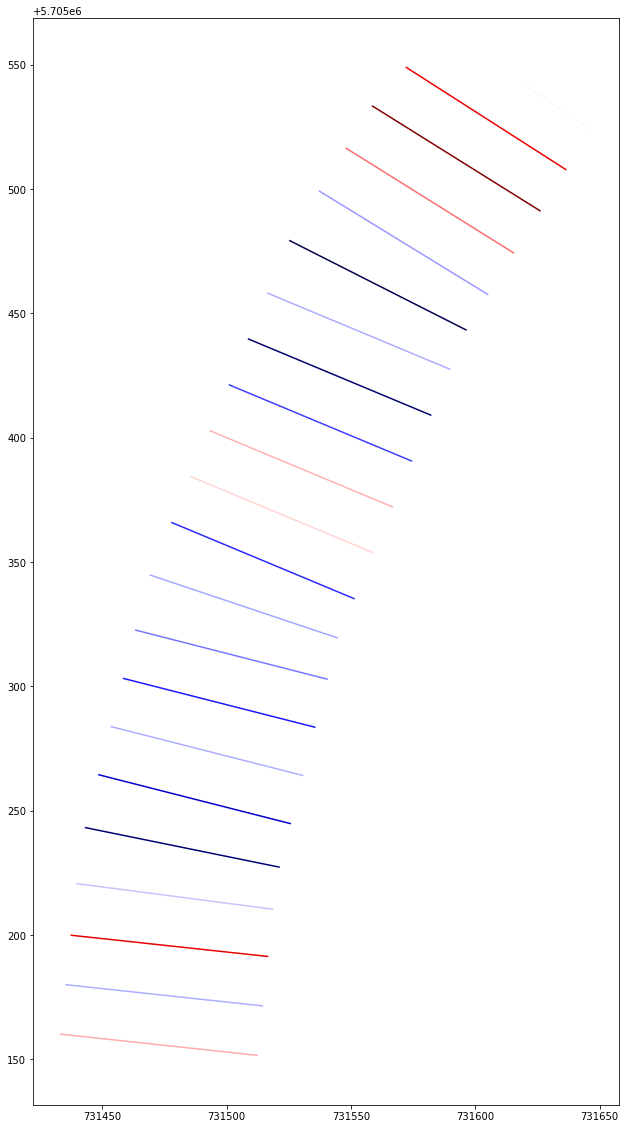

In [114]:
f,ax= plt.subplots(figsize=(20,20))

ss_transects_idx,idx_table=compute_rBCD_transects(dirNameTrans=dirNameTrans,label_order=label_order,
                                                  crs_dict_string=crs_dict_string,
                                                steady_state_tr=steady_state_tr,weights_dict=weights_dict,
                                                loc='mar')

ss_transects_idx.plot(column='residual', ax=ax, cmap='seismic_r');

In [246]:
n_trans=dataset.groupby(['tr_id'])["dt"].unique().reset_index()
n_trans['n_dt']=[n_trans.iloc[i,-1].shape[0] for i in np.arange(n_trans.shape[0]) ]

ss_transects_idx=pd.merge(ss_transects_idx,n_trans[["tr_id","n_dt"]], on=['tr_id'], how='left')
ss_transects_idx

,tr_id,erosion,deposition,residual,location,geometry,n_dt_x,n_dt_y,n_dt_x,n_dt_y
0,45,0.797168,0.791961,-0.005207,leo,"LINESTRING (299877.680 5773692.109, 299927.368...",NaN,6,6,6
1,46,0.788544,0.830032,0.041488,leo,"LINESTRING (299875.449 5773711.984, 299925.137...",NaN,6,6,6
2,47,0.669716,0.773256,0.103539,leo,"LINESTRING (299873.218 5773731.860, 299922.906...",NaN,6,6,6
3,48,0.749860,0.795782,0.045922,leo,"LINESTRING (299870.987 5773751.735, 299920.675...",NaN,6,6,6
4,49,0.738382,0.840372,0.101989,leo,"LINESTRING (299869.467 5773772.681, 299919.339...",NaN,6,6,6
5,50,0.874611,0.720929,-0.153682,leo,"LINESTRING (299868.295 5773792.997, 299918.212...",NaN,6,6,6
6,51,0.952226,0.716851,-0.235374,leo,"LINESTRING (299867.146 5773812.964, 299917.063...",NaN,6,6,6
7,52,0.813245,0.755008,-0.058237,leo,"LINESTRING (299865.996 5773832.931, 299915.914...",NaN,6,6,6
8,53,0.711310,0.796813,0.085503,leo,"LINESTRING (299864.847 5773852.898, 299914.765...",NaN,6,6,6
9,54,0.659353,0.697326,0.037973,leo,"LINESTRING (299863.698 5773872.865, 299913.615...",NaN,6,6,6


## Sensitivity analysis

For a reliable computation of r-BCDs at the transect scale the Δh points within the subaerial beachface must be beyond the period-specific LoDs.

This filtering process assures that only high quality data is used in the r-BCDs computation to the detriment of the total number of valid observations per transect. Moreover, two additional filtering steps are applied at the site-level, to ensure that are only retained:
* points that remain valid for at least a certain amount of Δh periods (t)
* transects that have a number of valid points greater than a determined minimum threshold (pt)

This is done to ensure comparability across time and transects in a determined location.
Therefore, __t is an important parameter that should ideally be as high as the available time periods__, in order to ensure that the maximum behavioural variability is captured.<br>
Yet, setting this parameter very high can reduce considerably the number of valid points retained in a single transect, which in turn can fall below t, leading to the loss of transects from the final behavioural map.<br>
It is also informative to monitor and try to minimise the number of transects that __passed from a depositional to erosional behavioral regime (or vice versa) in the last time period (i. e. changed sign from t-1 to t),__ for any chosen t. Those transects could signal a behaviour that only emerged by choosing a determined value for t, signaling a potentially __lower confidence in their r-BCD values__.<br>
For these reasons, the sensitivity analysis helps in choosing a __sub-optimal combination of t and p such as__:
* at least 85% (arbitrary) of the total transects are retained
* a reasonably low number of sign changes occurred

We start by defining all the combinations between the parameters __thresh (t)__ and __min_pts (pt)__, given ranges that we define.<br>
The thresh parameter can be up to the total number of timesteps available, while the min_pts, we decide to test the values from 0 to 210, with a step of 10.

In [28]:
range_thresh=range(0,dataset.dt.unique().shape[0]+1)
range_min_pts=range(0,100,10)
combs = list(itertools.product(range_min_pts,range_thresh))

And, we run the analysis.

In [29]:
%%time

ss_tr_big=pd.DataFrame()

for i in tqdm(combs):
    print(f"Working on threshold {i[1]} and min points {i[0]}.")
    try:
        ss_tr=steady_state_transect(dataset_mar,
                     field_unique_id='geometry',
                     thresh=i[1], min_points=i[0], unreal="drop" )
        if ss_tr.shape[0] > 0:
            ss_transects_idx,to_plot=compute_rBCD_transects(dirNameTrans=dirNameTrans,
                                                            label_order=label_order,
                                                            steady_state_tr=ss_tr,
                                                            loc='mar',
                                                            crs_dict_string=crs_dict_string,
                                                            weights_dict=weights_dict)
            ss_transects_idx['thresh']=i[1]
            ss_transects_idx['min_pts']=i[0]

            ss_tr_big=pd.concat([ss_tr_big,ss_transects_idx], ignore_index=True)

        else:
            pass
    except:
        print(f"Skipping")
    
ss_tr_big

  0%|          | 0/90 [00:00<?, ?it/s]

Working on threshold 0 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has not enough points. Go ahead...
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 24 has not enough points. Go ahead...
tr_id 5 has not enough points. Go ahead...
tr_id 4 has not enough points. Go ahead...
tr_id 3 has not enough points. Go ahead...
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 0.


  0%|          | 0/1 [00:00<?, ?it/s]

tr_id 18 has not enough points. Go ahead...
tr_id 13 has not enough points. Go ahead...
tr_id 12 has not enough points. Go ahead...
tr_id 10 has not enough points. Go ahead...
tr_id 9 has not enough points. Go ahead...
tr_id 6 has not enough points. Go ahead...
tr_id 24 has not enough points. Go ahead...
tr_id 23 has not enough points. Go ahead...
tr_id 22 has not enough points. Go ahead...
tr_id 21 has not enough points. Go ahead...
tr_id 7 has not enough points. Go ahead...
tr_id 5 has not enough points. Go ahead...
tr_id 4 has not enough points. Go ahead...
tr_id 3 has not enough points. Go ahead...
eliminating unreliable transects . . . 
Skipping
Working on threshold 0 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 5 not reached. It has 0 points.
tr_id 5 has not enough points. Go ahead...
Threshold of points per transect 4 not reached. It has 0 points.
tr_id 4 has not enough points. Go ahead...
Threshold of points per transect 3 not reached. It has 0 points.
tr_id 3 has not enough points. Go ahead...
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 10.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 20.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 20.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 20.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 20.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 20.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 20.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 20.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 5 not reached. It has 0 points.
tr_id 5 has not enough points. Go ahead...
Threshold of points per transect 4 not reached. It has 0 points.
tr_id 4 has not enough points. Go ahead...
Threshold of points per transect 3 not reached. It has 0 points.
tr_id 3 has not enough points. Go ahead...
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 20.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 30.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 30.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 30.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 30.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 30.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 30.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 30.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 21 not reached. It has 27 points.
Threshold of points per transect 5 not reached. It has 0 points.
tr_id 5 has not enough points. Go ahead...
Threshold of points per transect 4 not reached. It has 0 points.
tr_id 4 has not enough points. Go ahead...
Threshold of points per transect 3 not reached. It has 0 points.
tr_id 3 has not enough points. Go ahead...
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 30.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 40.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 40.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 40.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 40.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 40.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 40.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 40.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 21 not reached. It has 27 points.
Threshold of points per transect 5 not reached. It has 0 points.
tr_id 5 has not enough points. Go ahead...
Threshold of points per transect 4 not reached. It has 0 points.
tr_id 4 has not enough points. Go ahead...
Threshold of points per transect 3 not reached. It has 0 points.
tr_id 3

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 40.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 50.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 50.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 50.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 50.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 50.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 50.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 4 not reached. It has 44 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 50.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 22 not reached. It has 45 points.
Threshold of points per transect 21 not reached. It has 27 points.
Threshold of points per transect 5 not reached. It has 0 points.
tr_id 5 has not enough p

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 50.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 60.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 60.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 54 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 60.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 60.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 60.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 60.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 4 not reached. It has 44 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 60.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 14 not reached. It has 52 points.
Threshold of points per transect 13 not reached. It has 57 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 23 not reached. It has 52 points.
Threshold of points pe

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 8 and min points 60.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 70.


  0%|          | 0/1 [00:00<?, ?it/s]

eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 70.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 54 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 70.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 70.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 70.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 70.


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 4 not reached. It has 44 points.
Threshold of points per transect 3 not reached. It has 60 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 70.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 14 not reached. It has 52 points.
Threshold of points per transect 13 not reached. It has 57 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 23 not reached. It has 52 points.
Threshold of points pe

  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 80.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 80.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 54 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 80.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 80.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 80.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 80.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 4 not reached. It has 44 points.
Threshold of points per transect 3 not reached. It has 60 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 80.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 15 not reached. It has 76 points.
Threshold of points per transect 14 not reached. It has 52 points.
Threshold of points per transect 13 not reached. It has 57 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points pe

  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 1 and min points 90.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 79 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 2 and min points 90.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 54 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 3 and min points 90.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 39 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 4 and min points 90.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 20 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 5 and min points 90.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 3 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 6 and min points 90.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points per transect 4 not reached. It has 44 points.
Threshold of points per transect 3 not reached. It has 60 points.
eliminating unreliable transects . . . 


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


Working on threshold 7 and min points 90.


  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 31 points.
Threshold of points per transect 18 not reached. It has 24 points.
Threshold of points per transect 17 not reached. It has 36 points.
Threshold of points per transect 16 not reached. It has 31 points.
Threshold of points per transect 15 not reached. It has 76 points.
Threshold of points per transect 14 not reached. It has 52 points.
Threshold of points per transect 13 not reached. It has 57 points.
Threshold of points per transect 12 not reached. It has 29 points.
Threshold of points per transect 11 not reached. It has 22 points.
Threshold of points per transect 10 not reached. It has 14 points.
Threshold of points per transect 9 not reached. It has 32 points.
Threshold of points per transect 8 not reached. It has 47 points.
Threshold of points per transect 6 not reached. It has 45 points.
Threshold of points per transect 24 not reached. It has 0 points.
tr_id 24 has not enough points. Go ahead...
Threshold of points pe

  0%|          | 0/1 [00:00<?, ?it/s]

Threshold of points per transect 20 not reached. It has 4 points.
Threshold of points per transect 18 not reached. It has 0 points.
tr_id 18 has not enough points. Go ahead...
Threshold of points per transect 17 not reached. It has 1 points.
Threshold of points per transect 16 not reached. It has 1 points.
Threshold of points per transect 15 not reached. It has 1 points.
Threshold of points per transect 14 not reached. It has 1 points.
Threshold of points per transect 13 not reached. It has 0 points.
tr_id 13 has not enough points. Go ahead...
Threshold of points per transect 12 not reached. It has 0 points.
tr_id 12 has not enough points. Go ahead...
Threshold of points per transect 11 not reached. It has 1 points.
Threshold of points per transect 10 not reached. It has 0 points.
tr_id 10 has not enough points. Go ahead...
Threshold of points per transect 9 not reached. It has 0 points.
tr_id 9 has not enough points. Go ahead...
Threshold of points per transect 8 not reached. It has 1

process,location,tr_id,deposition,erosion,residual,geometry,thresh,min_pts
0,mar,3,0.424080,0.356589,0.067491,"MULTILINESTRING ((731512.461 5705151.584, 7314...",0,0
1,mar,4,0.464567,0.336649,0.127919,"MULTILINESTRING ((731514.605 5705171.469, 7314...",0,0
2,mar,5,0.375602,0.388622,-0.013021,"MULTILINESTRING ((731516.749 5705191.354, 7314...",0,0
3,mar,6,0.296762,0.176257,0.120505,"MULTILINESTRING ((731518.785 5705210.340, 7314...",0,0
4,mar,7,0.460313,0.196794,0.263519,"MULTILINESTRING ((731521.351 5705227.262, 7314...",0,0
...,...,...,...,...,...,...,...,...
1571,mar,19,0.643998,0.153892,0.490106,"MULTILINESTRING ((731596.497 5705443.265, 7315...",6,90
1572,mar,20,0.503569,0.331634,0.171935,"MULTILINESTRING ((731605.216 5705457.524, 7315...",6,90
1573,mar,21,0.477398,0.418235,0.059163,"MULTILINESTRING ((731615.645 5705474.209, 7315...",6,90
1574,mar,22,0.477237,0.426491,0.050746,"MULTILINESTRING ((731626.245 5705491.168, 7315...",6,90


Let's plot the transect r-BCDs in function of the thresh parameter.

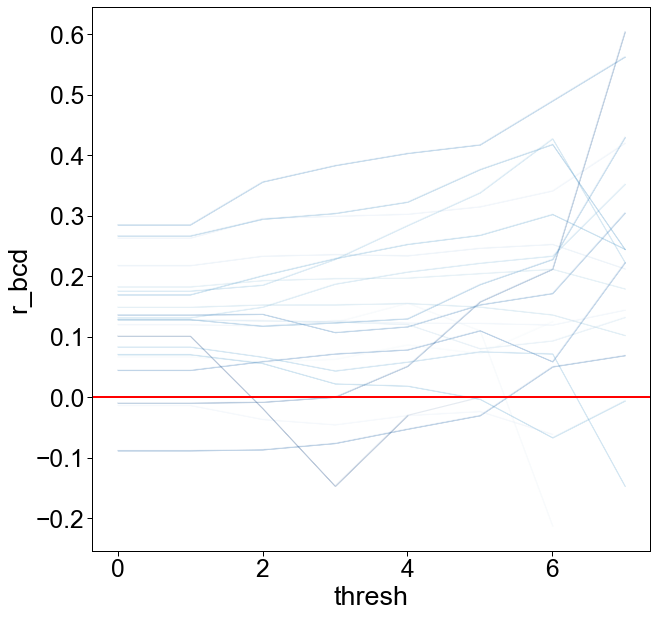

In [30]:
f,ax=plt.subplots(figsize=(10,10))

palette=sb.color_palette("Blues", n_colors=ss_tr_big.tr_id.unique().shape[0])
sb.lineplot(data=ss_tr_big, x='thresh',y='residual', hue='tr_id',
            palette=palette, legend=False, **dict(alpha=0.1),
            ax=ax
)
ax.set_ylabel("r_bcd")
ax.axhline(y=0, lw=2, c='r');

As we can see, there are only 3 transects that flipped their r-BCD sign (depo to ero or viceversa) as a consequence of an increase in the minimum number of timesteps.

In order to better decide a sub-optimal combination of thresh and min_pts that retains the majority of the transects (while keeping an eye on transects that flipped r-BCD), here below we do some plotting.

First, some preprocessing...

In [31]:
trs_res_ar=ss_tr_big.groupby(["tr_id","min_pts"])['residual'].apply(np.array).reset_index()
tot_trs=ss_tr_big.groupby(["thresh","min_pts"])['geometry'].count().reset_index()
tot_trs['trs_10']=tot_trs.geometry / 10
zero_crossings=pd.DataFrame([pd.Series({'tr_id':trs_res_ar.loc[i,'tr_id'],
                                        'sign_change_thresh':np.where(np.diff(np.sign(trs_res_ar.iloc[i,-1])))[0][-1]+1,
                                       'min_pts':trs_res_ar.loc[i,'min_pts']}) for i in range(trs_res_ar.shape[0]) if np.where(np.diff(np.sign(trs_res_ar.iloc[i,-1])))[0].shape[0] !=0])
tot_jumps=zero_crossings.groupby(["sign_change_thresh","min_pts"]).count().reset_index() # how many jumps per thresh and minpts

joined=pd.merge(tot_trs,tot_jumps, left_on=['thresh','min_pts'], right_on=['sign_change_thresh','min_pts'], how='left')
joined.rename({'geometry':'tot_trs',
              'tr_id':'tot_jumps'}, axis=1, inplace=True)
joined

,thresh,min_pts,tot_trs,trs_10,sign_change_thresh,tot_jumps
0,0,0,22,2.2,NaN,NaN
1,0,10,22,2.2,NaN,NaN
2,0,20,22,2.2,NaN,NaN
3,0,30,22,2.2,NaN,NaN
4,0,40,22,2.2,NaN,NaN
...,...,...,...,...,...,...
72,7,20,17,1.7,7.0,1.0
73,7,30,13,1.3,7.0,1.0
74,7,40,9,0.9,7.0,1.0
75,7,50,6,0.6,7.0,1.0


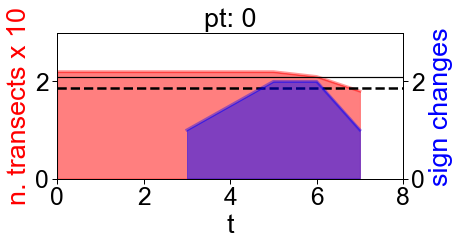

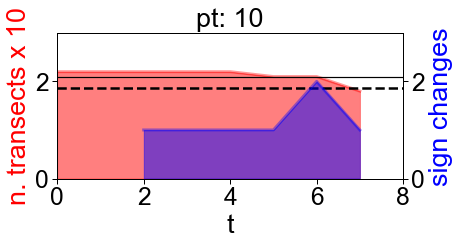

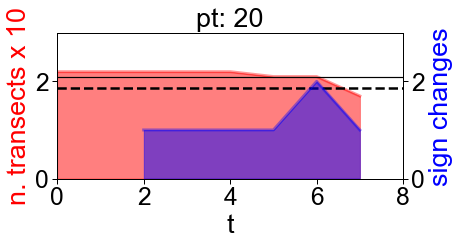

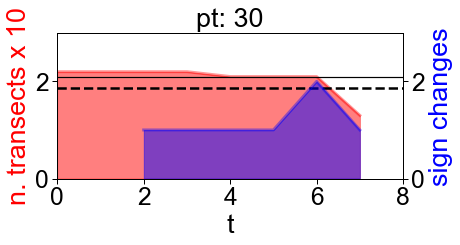

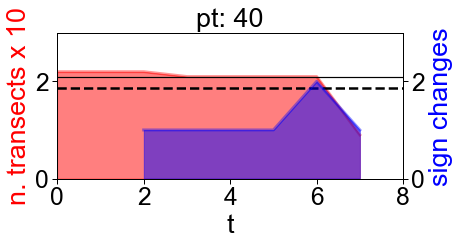

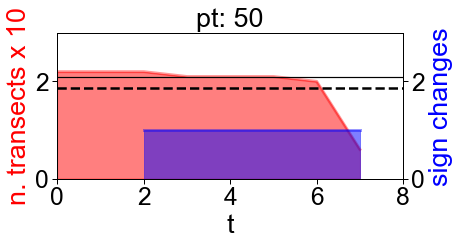

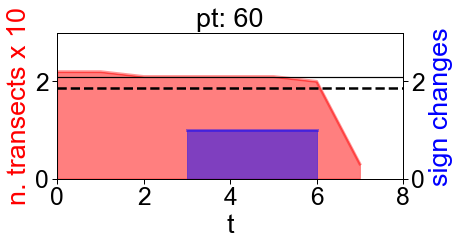

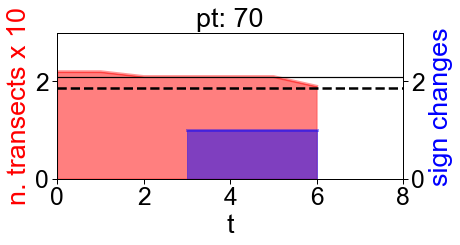

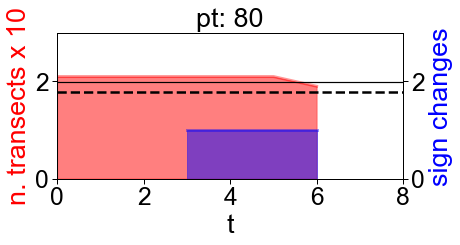

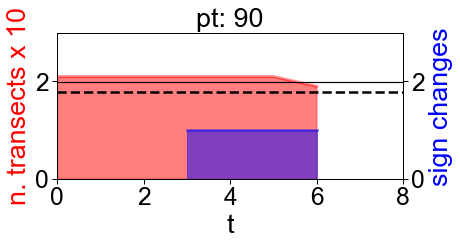

In [32]:
plt.rcParams['font.sans-serif'] = 'Arial'
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = 'sans-serif'
sb.set_context("paper", font_scale=2.8)


x_ticks=[0,2,4,6,8]

q_up_val=0.95
q_low_val=0.85

list_minpts=ss_tr_big.min_pts.unique()

for minpts in list_minpts:

    f,ax=plt.subplots(figsize=(7,4))
    ax2=ax.twinx()
    
    datain=joined.query(f"min_pts=={minpts}")  


    sb.lineplot(x="thresh", y="tot_jumps",ci=None,
                    data=datain,color='b',
                   alpha=.4,linewidth=3,
                ax=ax2, label="sign changes")

    sb.lineplot(data=datain,x='thresh',y='trs_10',
                alpha=.4,color='r',linewidth=3,
                ax=ax,label="transects * 10")
    
    
    kde_x, kde_y = ax.lines[0].get_data()
    kde_x2, kde_y2 = ax2.lines[0].get_data()
    ax.fill_between(kde_x, kde_y,interpolate=True, color='r',alpha=0.5)
    ax2.fill_between(kde_x2, kde_y2,interpolate=True,color='b',alpha=0.5)
    
    ax.axhline((datain.tot_trs.fillna(0).max()*q_up_val)/10,c='k',ls='-',label='95%')
    ax.axhline((datain.tot_trs.fillna(0).max()*q_low_val)/10,c='k',lw=2.5,ls='--',label='85%')
    
    ax.set_ylabel('n. transects x 10', c='r')
    ax.set_xlabel('t')
    ax2.set_ylabel('sign changes', c='b')
    ax2.set_ylim(0,3)
    ax.set_ylim(0,3)
    ax.set_xlim(0,8)
    

    plt.tight_layout()
    ax.get_legend().remove()
    ax2.get_legend().remove()
    
    
    plt.xticks(x_ticks)
    savetxt=f"E:\\path\\to\\save\\revision_0\\location_sensit_minpts_{minpts}.png"
    
    ax.set_title(f"pt: {minpts}")
    plt.tight_layout()
    
#   f.savefig(savetxt, dpi=600); #uncomment to save all images

___